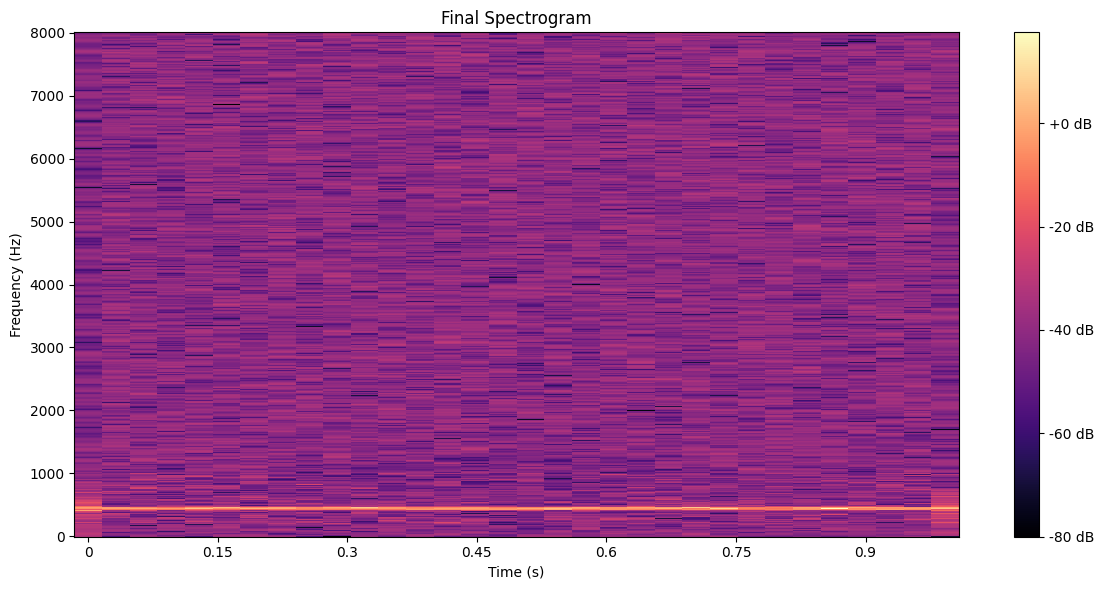

In [4]:
# =========================================================
# 1) 필요한 라이브러리
# =========================================================
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
from abc import ABC, abstractmethod


# =========================================================
# 2) 스펙트로그램 처리
# =========================================================
class SpectrogramModifier:
    def __init__(self, sample_rate=16000, n_fft=1024, hop_length=512,
                 noise_strength=0.1, noise_type='normal', noise_params=None):
        self.sample_rate = sample_rate
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.noise_strength = noise_strength
        self.noise_type = noise_type
        self.noise_params = noise_params if noise_params else {}
        self.signal = None
        self.signal_with_noise = None
        self.S_db = None

    def compute_spectrogram(self, signal):
        self.signal = signal
        self.signal_with_noise = self._add_noise(signal)
        S = np.abs(librosa.stft(
            self.signal_with_noise,
            n_fft=self.n_fft,
            hop_length=self.hop_length,
            window='hann'
        ))
        self.S_db = librosa.amplitude_to_db(S, ref=np.max)
        return self.S_db

    def _add_noise(self, signal):
        noise = self._generate_noise(len(signal))
        return signal + noise * self.noise_strength

    def _generate_noise(self, length):
        if self.noise_type == 'normal':
            mean = self.noise_params.get('mean', 0.0)
            std = self.noise_params.get('std', 1.0)
            return np.random.normal(mean, std, length)
        elif self.noise_type == 'uniform':
            low = self.noise_params.get('low', -1.0)
            high = self.noise_params.get('high', 1.0)
            return np.random.uniform(low, high, length)
        else:
            return np.zeros(length)

    def apply_dB_mask(self, dB_mask):
        if self.S_db is not None:
            self.S_db += dB_mask

    def _get_freqs(self):
        return np.linspace(0, self.sample_rate / 2, self.S_db.shape[0])

    def _get_times(self):
        frames = np.arange(self.S_db.shape[1])
        return librosa.frames_to_time(frames, sr=self.sample_rate, hop_length=self.hop_length)

    def plot_spectrogram(self, show_labels=True, colormap='magma', title='Spectrogram'):
        if self.S_db is None:
            raise ValueError("compute_spectrogram()를 먼저 호출하세요.")
        fig, ax = plt.subplots(figsize=(12, 6))
        img = librosa.display.specshow(
            self.S_db,
            sr=self.sample_rate,
            hop_length=self.hop_length,
            x_axis='time',
            y_axis='linear',
            ax=ax,
            cmap=colormap
        )
        if show_labels:
            ax.set_xlabel('Time (s)')
            ax.set_ylabel('Frequency (Hz)')
            ax.set_title(title)
            fig.colorbar(img, ax=ax, format="%+2.0f dB")
        else:
            ax.axis('off')
            plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
        plt.tight_layout()
        return fig, ax


# =========================================================
# 3) 분포 추상화 및 엔진
# =========================================================
class Distribution(ABC):
    @abstractmethod
    def sample(self, shape):
        pass


class NormalDistribution(Distribution):
    def __init__(self, mean=0.0, stddev=1.0):
        self.mean = mean
        self.stddev = stddev

    def sample(self, shape):
        return np.random.normal(self.mean, self.stddev, shape)


class UniformDistribution(Distribution):
    def __init__(self, min_val=-1.0, max_val=1.0):
        self.min_val = min_val
        self.max_val = max_val

    def sample(self, shape):
        return np.random.uniform(self.min_val, self.max_val, shape)


class NoneDistribution(Distribution):
    def sample(self, shape):
        return np.zeros(shape)


class PoissonDistribution(Distribution):
    def __init__(self, lam=5):
        self.lam = lam

    def sample(self, shape):
        return np.random.poisson(self.lam, shape).astype(float)


class ExponentialDistribution(Distribution):
    def __init__(self, scale=1.0):
        self.scale = scale

    def sample(self, shape):
        noise = np.random.exponential(self.scale, shape)
        noise -= np.mean(noise)
        return noise


class CauchyDistribution(Distribution):
    def sample(self, shape):
        noise = np.random.standard_cauchy(shape)
        noise = np.clip(noise, -10, 10)
        noise /= np.max(np.abs(noise))
        return noise


class LaplaceDistribution(Distribution):
    def __init__(self, loc=0.0, scale=1.0):
        self.loc = loc
        self.scale = scale

    def sample(self, shape):
        return np.random.laplace(self.loc, self.scale, shape)


class BetaDistribution(Distribution):
    def __init__(self, a=2.0, b=2.0):
        self.a = a
        self.b = b

    def sample(self, shape):
        noise = np.random.beta(self.a, self.b, shape)
        noise = (noise - 0.5) * 2
        return noise


class GammaDistribution(Distribution):
    def __init__(self, shape_param=2.0, scale=1.0):
        self.shape_param = shape_param
        self.scale = scale

    def sample(self, shape):
        noise = np.random.gamma(self.shape_param, self.scale, shape)
        noise -= np.mean(noise)
        noise /= (np.std(noise) + 1e-9)
        return noise


class ChiSquareDistribution(Distribution):
    def __init__(self, df=2):
        self.df = df

    def sample(self, shape):
        noise = np.random.chisquare(self.df, shape)
        noise -= np.mean(noise)
        noise /= (np.std(noise) + 1e-9)
        return noise


class DistributionEngine:
    def create(self, dist_type, **params):
        dist_type = dist_type.lower()
        if dist_type == "normal":
            return NormalDistribution(params.get('mean', 0.0), params.get('stddev', 1.0))
        elif dist_type == "uniform":
            return UniformDistribution(params.get('min', -1.0), params.get('max', 1.0))
        elif dist_type == "poisson":
            return PoissonDistribution(params.get('lam', 5))
        elif dist_type == "exponential":
            return ExponentialDistribution(params.get('scale', 1.0))
        elif dist_type == "cauchy":
            return CauchyDistribution()
        elif dist_type == "laplace":
            return LaplaceDistribution(params.get('loc', 0.0), params.get('scale', 1.0))
        elif dist_type == "beta":
            return BetaDistribution(params.get('a', 2.0), params.get('b', 2.0))
        elif dist_type == "gamma":
            return GammaDistribution(params.get('shape_param', 2.0),
                                     params.get('scale', 1.0))
        elif dist_type == "chisquare":
            return ChiSquareDistribution(params.get('df', 2))
        else:
            return NoneDistribution()


# =========================================================
# 4) Shape(도형) 계층
#   - '중심으로부터의 거리'에 따른 스케일링을 추가.
#   - 분포 엔진을 통해 샘플링된 dist_values와 곱해 최종 dB 마스크 적용.
# =========================================================
class DBShape(ABC):
    @abstractmethod
    def create_mask(self, spectro_shape, spectro_mod):
        pass


class BaseShape(DBShape):
    def __init__(self, distribution_engine,
                 distribution_type='none', distribution_params=None,
                 strength_dB=5.0, alpha=1.0):
        """
        distribution_engine: 분포 엔진
        distribution_type, distribution_params: 어떤 분포를 사용할지 설정
        strength_dB: 도형 자체가 가지는 기본 dB
        alpha: distance_scale에 사용되는 파라미터 (멀어질수록 증폭/감소 등을 조절)
        """
        self.distribution_engine = distribution_engine
        self.distribution_type = distribution_type
        self.distribution_params = distribution_params if distribution_params else {}
        self.strength_dB = strength_dB
        self.alpha = alpha

    def _sample_distribution(self, shape):
        dist_obj = self.distribution_engine.create(
            self.distribution_type,
            **self.distribution_params
        )
        return dist_obj.sample(shape)

    @abstractmethod
    def generate_shape_mask_and_dist(self, spectro_shape, spectro_mod):
        """
        shape_mask: 0 또는 1(또는 0~1)
        dist_map:   shape 내부 각 지점까지의 '정규화된' 거리(0~1)
        """
        pass

    def _distance_scale(self, dist):
        """
        기본 예시: 멀어질수록 점진적 증가
        scale = 1 + alpha * dist
        필요 시 다른 식으로 교체 가능.
        """
        return 1.0 + self.alpha * dist

    def create_mask(self, spectro_shape, spectro_mod):
        shape_mask, dist_map = self.generate_shape_mask_and_dist(spectro_shape, spectro_mod)

        # 1) 분포 샘플링
        dist_values = self._sample_distribution(spectro_shape)  # 2D 배열

        # 2) 거리 기반 스케일
        scale_map = self._distance_scale(dist_map)

        # 최종 마스크 = shape_mask * dist_values * scale_map * strength_dB
        return shape_mask * dist_values * scale_map * self.strength_dB


# ---------------------------------------------------------
# Circle
# ---------------------------------------------------------
class CircleDBShape(BaseShape):
    def __init__(self, center_freq, center_time,
                 radius_freq, radius_time,
                 distribution_engine,
                 distribution_type='none',
                 distribution_params=None,
                 strength_dB=5.0, alpha=1.0):
        super().__init__(
            distribution_engine, distribution_type, distribution_params,
            strength_dB, alpha
        )
        self.center_freq = center_freq
        self.center_time = center_time
        self.radius_freq = radius_freq
        self.radius_time = radius_time

    def generate_shape_mask_and_dist(self, spectro_shape, spectro_mod):
        freqs = spectro_mod._get_freqs()
        times = spectro_mod._get_times()
        ff, tt = np.meshgrid(freqs, times, indexing='ij')
        dist_norm = ((ff - self.center_freq)**2 / (self.radius_freq**2) +
                     (tt - self.center_time)**2 / (self.radius_time**2))
        circle_mask = (dist_norm <= 1).astype(float)
        dist_map = np.sqrt(dist_norm)  # 0~1
        dist_map[circle_mask == 0] = 0
        return circle_mask, dist_map


# ---------------------------------------------------------
# Trapezoid
# ---------------------------------------------------------
class TrapezoidDBShape(BaseShape):
    def __init__(self, freq_min, freq_max, time_min, time_max,
                 slope_freq, slope_time,
                 distribution_engine,
                 distribution_type='none',
                 distribution_params=None,
                 strength_dB=5.0, alpha=1.0):
        super().__init__(
            distribution_engine, distribution_type, distribution_params,
            strength_dB, alpha
        )
        self.freq_min = freq_min
        self.freq_max = freq_max
        self.time_min = time_min
        self.time_max = time_max
        self.slope_freq = slope_freq
        self.slope_time = slope_time

        self.center_freq = 0.5 * (freq_min + freq_max)
        self.center_time = 0.5 * (time_min + time_max)

    def generate_shape_mask_and_dist(self, spectro_shape, spectro_mod):
        mask = np.zeros(spectro_shape)
        freqs = spectro_mod._get_freqs()
        times = spectro_mod._get_times()
        freq_mask = (freqs >= self.freq_min) & (freqs <= self.freq_max)
        time_mask = (times >= self.time_min) & (times <= self.time_max)
        f_inds = np.where(freq_mask)[0]
        t_inds = np.where(time_mask)[0]
        if len(f_inds) == 0 or len(t_inds) == 0:
            dist_map = np.zeros(spectro_shape)
            return mask, dist_map

        f_dist = (freqs[f_inds] - self.freq_min) / (self.freq_max - self.freq_min)
        t_dist = (times[t_inds] - self.time_min) / (self.time_max - self.time_min)

        for i, fi in enumerate(f_inds):
            for j, ti in enumerate(t_inds):
                val = 1.0
                val *= (1 - abs(f_dist[i] - 0.5) * 2 * self.slope_freq)
                val *= (1 - abs(t_dist[j] - 0.5) * 2 * self.slope_time)
                if val < 0:
                    val = 0
                mask[fi, ti] = val

        ff, tt = np.meshgrid(freqs, times, indexing='ij')
        max_freq_dist = (self.freq_max - self.freq_min)/2.0
        max_time_dist = (self.time_max - self.time_min)/2.0
        freq_norm = (ff - self.center_freq)/max_freq_dist if max_freq_dist != 0 else 0
        time_norm = (tt - self.center_time)/max_time_dist if max_time_dist != 0 else 0
        dist_map = np.sqrt(freq_norm**2 + time_norm**2)
        dist_map[mask == 0] = 0
        return mask, dist_map


# ---------------------------------------------------------
# Spike
# ---------------------------------------------------------
class SpikeDBShape(BaseShape):
    def __init__(self, center_freq, center_time,
                 radius_freq, radius_time,
                 distribution_engine,
                 distribution_type='none',
                 distribution_params=None,
                 strength_dB=5.0, alpha=1.0,
                 rotate_deg=0.0):
        super().__init__(
            distribution_engine, distribution_type, distribution_params,
            strength_dB, alpha
        )
        self.center_freq = center_freq
        self.center_time = center_time
        self.radius_freq = radius_freq
        self.radius_time = radius_time
        self.rotate_deg = rotate_deg

    def generate_shape_mask_and_dist(self, spectro_shape, spectro_mod):
        freqs = spectro_mod._get_freqs()
        times = spectro_mod._get_times()
        ff, tt = np.meshgrid(freqs, times, indexing='ij')

        f_shift = ff - self.center_freq
        t_shift = tt - self.center_time

        angle_rad = np.deg2rad(self.rotate_deg)
        cos_a = np.cos(angle_rad)
        sin_a = np.sin(angle_rad)

        f_rot = f_shift * cos_a - t_shift * sin_a
        t_rot = f_shift * sin_a + t_shift * cos_a

        dist_norm = (f_rot**2)/(self.radius_freq**2) + (t_rot**2)/(self.radius_time**2)
        spike_mask = (dist_norm <= 1).astype(float)
        dist_map = np.sqrt(dist_norm)
        dist_map[spike_mask == 0] = 0
        return spike_mask, dist_map


# ---------------------------------------------------------
# Pillar
# ---------------------------------------------------------
class PillarDBShape(BaseShape):
    def __init__(self, freq_min, freq_max,
                 distribution_engine,
                 distribution_type='none',
                 distribution_params=None,
                 strength_dB=5.0, alpha=1.0):
        super().__init__(
            distribution_engine, distribution_type, distribution_params,
            strength_dB, alpha
        )
        self.freq_min = freq_min
        self.freq_max = freq_max
        self.center_freq = 0.5*(freq_min + freq_max)

    def generate_shape_mask_and_dist(self, spectro_shape, spectro_mod):
        mask = np.zeros(spectro_shape)
        freqs = spectro_mod._get_freqs()

        freq_indices = np.where((freqs >= self.freq_min) & (freqs <= self.freq_max))[0]
        if len(freq_indices) == 0:
            dist_map = np.zeros(spectro_shape)
            return mask, dist_map
        mask[freq_indices, :] = 1.0

        # 거리 맵 (freq축 중심 기준)
        max_dist = (self.freq_max - self.freq_min) / 2.0 if (self.freq_max > self.freq_min) else 1
        ff = freqs[:, np.newaxis]  # (freq_bins, 1)
        dist_map_1d = np.abs(ff - self.center_freq)/max_dist
        dist_map = np.repeat(dist_map_1d, spectro_shape[1], axis=1)
        dist_map[mask == 0] = 0
        return mask, dist_map


# ---------------------------------------------------------
# Rectangle
# ---------------------------------------------------------
class RectangleDBShape(BaseShape):
    def __init__(self, freq_min, freq_max, time_min, time_max,
                 distribution_engine,
                 distribution_type='none',
                 distribution_params=None,
                 strength_dB=5.0, alpha=1.0):
        super().__init__(
            distribution_engine, distribution_type, distribution_params,
            strength_dB, alpha
        )
        self.freq_min = freq_min
        self.freq_max = freq_max
        self.time_min = time_min
        self.time_max = time_max
        self.center_freq = 0.5*(freq_min + freq_max)
        self.center_time = 0.5*(time_min + time_max)

    def generate_shape_mask_and_dist(self, spectro_shape, spectro_mod):
        freqs = spectro_mod._get_freqs()
        times = spectro_mod._get_times()
        mask = np.zeros(spectro_shape)

        freq_indices = np.where((freqs >= self.freq_min) & (freqs <= self.freq_max))[0]
        time_indices = np.where((times >= self.time_min) & (times <= self.time_max))[0]
        if len(freq_indices) == 0 or len(time_indices) == 0:
            dist_map = np.zeros(spectro_shape)
            return mask, dist_map

        mask[np.ix_(freq_indices, time_indices)] = 1.0

        ff, tt = np.meshgrid(freqs, times, indexing='ij')
        freq_span = max(1e-9, 0.5*(self.freq_max - self.freq_min))
        time_span = max(1e-9, 0.5*(self.time_max - self.time_min))

        freq_norm = (ff - self.center_freq)/freq_span
        time_norm = (tt - self.center_time)/time_span
        dist_map = np.sqrt(freq_norm**2 + time_norm**2)
        dist_map[mask == 0] = 0
        return mask, dist_map


# ---------------------------------------------------------
# Ellipse
# ---------------------------------------------------------
class EllipseDBShape(BaseShape):
    def __init__(self, center_freq, center_time,
                 radius_freq, radius_time,
                 distribution_engine,
                 distribution_type='none',
                 distribution_params=None,
                 strength_dB=5.0, alpha=1.0):
        super().__init__(
            distribution_engine, distribution_type, distribution_params,
            strength_dB, alpha
        )
        self.center_freq = center_freq
        self.center_time = center_time
        self.radius_freq = radius_freq
        self.radius_time = radius_time

    def generate_shape_mask_and_dist(self, spectro_shape, spectro_mod):
        freqs = spectro_mod._get_freqs()
        times = spectro_mod._get_times()
        ff, tt = np.meshgrid(freqs, times, indexing='ij')

        dist_norm = ((ff - self.center_freq)**2)/(self.radius_freq**2) + \
                    ((tt - self.center_time)**2)/(self.radius_time**2)
        ellipse_mask = (dist_norm <= 1).astype(float)
        dist_map = np.sqrt(dist_norm)
        dist_map[ellipse_mask == 0] = 0
        return ellipse_mask, dist_map


# ---------------------------------------------------------
# Hill
# ---------------------------------------------------------
class HillDBShape(BaseShape):
    def __init__(self, freq_center, time_center, freq_width, time_width,
                 distribution_engine,
                 distribution_type='none',
                 distribution_params=None,
                 strength_dB=5.0, alpha=1.0):
        super().__init__(
            distribution_engine, distribution_type, distribution_params,
            strength_dB, alpha
        )
        self.freq_center = freq_center
        self.time_center = time_center
        self.freq_width = freq_width
        self.time_width = time_width

    def generate_shape_mask_and_dist(self, spectro_shape, spectro_mod):
        freqs = spectro_mod._get_freqs()
        times = spectro_mod._get_times()
        ff, tt = np.meshgrid(freqs, times, indexing='ij')
        dist = np.sqrt(((ff - self.freq_center)**2)/(self.freq_width**2) +
                       ((tt - self.time_center)**2)/(self.time_width**2))
        hill_mask = (1 - dist)
        hill_mask[hill_mask < 0] = 0
        dist_map = dist
        dist_map[hill_mask == 0] = 0
        return hill_mask, dist_map


# ---------------------------------------------------------
# Fog
# ---------------------------------------------------------
class FogDBShape(BaseShape):
    def __init__(self, strength_dB=3.0, coverage=1.0,
                 distribution_engine=None,
                 distribution_type='none',
                 distribution_params=None,
                 alpha=1.0):
        super().__init__(
            distribution_engine, distribution_type, distribution_params,
            strength_dB, alpha
        )
        self.coverage = coverage

    def generate_shape_mask_and_dist(self, spectro_shape, spectro_mod):
        mask = np.zeros(spectro_shape)
        random_map = np.random.uniform(0, 1, spectro_shape)
        mask[random_map < self.coverage] = 1.0

        freqs = spectro_mod._get_freqs()
        times = spectro_mod._get_times()
        f_center = (freqs[0] + freqs[-1]) / 2.0
        t_center = (times[0] + times[-1]) / 2.0
        ff, tt = np.meshgrid(freqs, times, indexing='ij')

        freq_range = max(1e-9, freqs[-1] - freqs[0])
        time_range = max(1e-9, times[-1] - times[0])
        freq_norm = (ff - f_center)/freq_range
        time_norm = (tt - t_center)/time_range
        dist_map = np.sqrt(freq_norm**2 + time_norm**2)
        dist_map[mask == 0] = 0
        return mask, dist_map


# ---------------------------------------------------------
# Polygon
# ---------------------------------------------------------
class PolygonDBShape(BaseShape):
    def __init__(self, vertices,
                 distribution_engine,
                 distribution_type='none',
                 distribution_params=None,
                 strength_dB=5.0, alpha=1.0):
        super().__init__(
            distribution_engine, distribution_type, distribution_params,
            strength_dB, alpha
        )
        self.vertices = vertices
        vs = np.array(vertices)
        self.center_freq = np.mean(vs[:, 0])
        self.center_time = np.mean(vs[:, 1])

    def generate_shape_mask_and_dist(self, spectro_shape, spectro_mod):
        from matplotlib.path import Path
        freqs = spectro_mod._get_freqs()
        times = spectro_mod._get_times()
        ff, tt = np.meshgrid(freqs, times, indexing='ij')

        path = Path(self.vertices)
        points = np.vstack((ff.ravel(), tt.ravel())).T
        inside = path.contains_points(points).reshape(ff.shape)

        mask = np.zeros(spectro_shape)
        mask[inside] = 1.0

        freq_range = max(1e-9, freqs[-1] - freqs[0])
        time_range = max(1e-9, times[-1] - times[0])
        freq_norm = (ff - self.center_freq)/freq_range
        time_norm = (tt - self.center_time)/time_range
        dist_map = np.sqrt(freq_norm**2 + time_norm**2)
        dist_map[mask == 0] = 0
        return mask, dist_map


# ---------------------------------------------------------
# WavePattern
# ---------------------------------------------------------
class WavePatternDBShape(BaseShape):
    def __init__(self, axis='time', frequency=1.0,
                 distribution_engine=None,
                 distribution_type='none',
                 distribution_params=None,
                 strength_dB=5.0, alpha=1.0):
        super().__init__(
            distribution_engine, distribution_type, distribution_params,
            strength_dB, alpha
        )
        self.axis = axis
        self.frequency = frequency

    def generate_shape_mask_and_dist(self, spectro_shape, spectro_mod):
        freqs = spectro_mod._get_freqs()
        times = spectro_mod._get_times()
        ff, tt = np.meshgrid(freqs, times, indexing='ij')

        mask = np.zeros(spectro_shape)
        if self.axis == 'time':
            wave = np.sin(2*np.pi*self.frequency*times)  # shape=(time_frames,)
            mask += (wave[np.newaxis, :] > 0).astype(float)
        else:
            wave = np.sin(2*np.pi*self.frequency*freqs)  # shape=(freq_bins,)
            mask += (wave[:, np.newaxis] > 0).astype(float)

        # 스펙트럼 중앙 기준 dist_map
        f_center = (freqs[0] + freqs[-1]) / 2.0
        t_center = (times[0] + times[-1]) / 2.0
        freq_range = max(1e-9, freqs[-1] - freqs[0])
        time_range = max(1e-9, times[-1] - times[0])
        freq_norm = (ff - f_center)/freq_range
        time_norm = (tt - t_center)/time_range
        dist_map = np.sqrt(freq_norm**2 + time_norm**2)

        dist_map[mask == 0] = 0
        return mask, dist_map


# ---------------------------------------------------------
# RealWorldNoise
# ---------------------------------------------------------
class RealWorldNoiseDBShape(BaseShape):
    def __init__(self, audio_path, freq_min, freq_max, time_min, time_max,
                 distribution_engine=None,
                 distribution_type='none',
                 distribution_params=None,
                 strength_dB=0.0, alpha=1.0):
        super().__init__(
            distribution_engine, distribution_type, distribution_params,
            strength_dB, alpha
        )
        self.audio_path = audio_path
        self.freq_min = freq_min
        self.freq_max = freq_max
        self.time_min = time_min
        self.time_max = time_max

    def generate_shape_mask_and_dist(self, spectro_shape, spectro_mod):
        y, _ = librosa.load(self.audio_path, sr=spectro_mod.sample_rate)
        S = np.abs(librosa.stft(y, n_fft=spectro_mod.n_fft, hop_length=spectro_mod.hop_length))
        S_db = librosa.amplitude_to_db(S, ref=np.max)

        freqs = spectro_mod._get_freqs()
        times = spectro_mod._get_times()
        freq_indices = np.where((freqs >= self.freq_min) & (freqs <= self.freq_max))[0]
        time_indices = np.where((times >= self.time_min) & (times <= self.time_max))[0]

        mask = np.zeros(spectro_shape)
        if len(freq_indices) == 0 or len(time_indices) == 0:
            dist_map = np.zeros(spectro_shape)
            return mask, dist_map

        f_cut = min(len(freq_indices), S_db.shape[0])
        t_cut = min(len(time_indices), S_db.shape[1])
        mask[freq_indices[:f_cut], time_indices[:t_cut]] = 1.0

        # 중심
        f_center = 0.5*(self.freq_min + self.freq_max)
        t_center = 0.5*(self.time_min + self.time_max)
        ff, tt = np.meshgrid(freqs, times, indexing='ij')
        f_span = max(1e-9, 0.5*(self.freq_max - self.freq_min))
        t_span = max(1e-9, 0.5*(self.time_max - self.time_min))
        freq_norm = (ff - f_center)/f_span
        time_norm = (tt - t_center)/t_span
        dist_map = np.sqrt(freq_norm**2 + time_norm**2)
        dist_map[mask == 0] = 0
        return mask, dist_map


# ---------------------------------------------------------
# Horizontal / Vertical Line, RangeDistribution 등
# 필요하다면 위와 같은 방식으로 수정 가능
# ---------------------------------------------------------


# =========================================================
# 5) Pattern(패턴) 계층
# =========================================================
class Pattern(ABC):
    @abstractmethod
    def create_mask(self, spectro_shape, spectro_mod, shape_factory, distribution_engine):
        pass


class LinearPattern(Pattern):
    def __init__(self, shape_name, shape_params,
                 direction='time', repeat=5, spacing=1.0):
        self.shape_name = shape_name
        self.shape_params = shape_params
        self.direction = direction
        self.repeat = repeat
        self.spacing = spacing

    def create_mask(self, spectro_shape, spectro_mod, shape_factory, distribution_engine):
        mask = np.zeros(spectro_shape)
        for i in range(self.repeat):
            offset = i * self.spacing
            params = self.shape_params.copy()

            if self.direction == 'time' and 'center_time' in params:
                params['center_time'] += offset
            elif self.direction == 'freq' and 'center_freq' in params:
                params['center_freq'] += offset

            shape_obj = shape_factory.create(self.shape_name, **params)
            if shape_obj is not None:
                mask += shape_obj.create_mask(spectro_shape, spectro_mod)
        return mask


class RandomPattern(Pattern):
    def __init__(self, shape_name, shape_params, n=10,
                 freq_range=None, time_range=None):
        self.shape_name = shape_name
        self.shape_params = shape_params
        self.n = n
        self.freq_range = freq_range if freq_range else (0, 8000)
        self.time_range = time_range if time_range else (0.0, 10.0)

    def create_mask(self, spectro_shape, spectro_mod, shape_factory, distribution_engine):
        mask = np.zeros(spectro_shape)
        for _ in range(self.n):
            params = self.shape_params.copy()
            if 'center_freq' in params:
                params['center_freq'] = np.random.uniform(*self.freq_range)
            if 'center_time' in params:
                params['center_time'] = np.random.uniform(*self.time_range)

            shape_obj = shape_factory.create(self.shape_name, **params)
            if shape_obj is not None:
                mask += shape_obj.create_mask(spectro_shape, spectro_mod)
        return mask


class NLinearRepeatTSleepPattern(Pattern):
    def __init__(self, shape_name, shape_params,
                 repeat=3, repeat_time=0.5, sleep_time=5.0,
                 start_time=0.0):
        self.shape_name = shape_name
        self.shape_params = shape_params
        self.repeat = repeat
        self.repeat_time = repeat_time
        self.sleep_time = sleep_time
        self.start_time = start_time

    def create_mask(self, spectro_shape, spectro_mod, shape_factory, distribution_engine):
        mask = np.zeros(spectro_shape)
        current_time = self.start_time
        for _ in range(self.repeat):
            params = self.shape_params.copy()
            if 'center_time' in params:
                params['center_time'] = current_time

            shape_obj = shape_factory.create(self.shape_name, **params)
            if shape_obj is not None:
                mask += shape_obj.create_mask(spectro_shape, spectro_mod)
            current_time += self.repeat_time

        current_time += self.sleep_time
        return mask


class ConvexPattern(Pattern):
    def __init__(self, shape_name, shape_params,
                 freq_min, freq_max, time_min, time_max,
                 n=10):
        self.shape_name = shape_name
        self.shape_params = shape_params
        self.freq_min = freq_min
        self.freq_max = freq_max
        self.time_min = time_min
        self.time_max = time_max
        self.n = n

    def create_mask(self, spectro_shape, spectro_mod, shape_factory, distribution_engine):
        mask = np.zeros(spectro_shape)
        freqs = np.linspace(self.freq_min, self.freq_max, self.n)
        times = np.linspace(self.time_min, self.time_max, self.n)

        for i in range(self.n):
            params = self.shape_params.copy()
            if 'center_freq' in params:
                params['center_freq'] = freqs[i]
            if 'center_time' in params:
                params['center_time'] = times[i]

            shape_obj = shape_factory.create(self.shape_name, **params)
            if shape_obj is not None:
                mask += shape_obj.create_mask(spectro_shape, spectro_mod)
        return mask


class FunctionPattern(Pattern):
    def __init__(self, func):
        self.func = func

    def create_mask(self, spectro_shape, spectro_mod, shape_factory, distribution_engine):
        freqs = spectro_mod._get_freqs()
        times = spectro_mod._get_times()
        ff, tt = np.meshgrid(freqs, times, indexing='ij')
        return self.func(ff, tt)


# =========================================================
# 6) 팩토리
# =========================================================
class ShapeFactory:
    def __init__(self, distribution_engine):
        self.distribution_engine = distribution_engine

    def create(self, shape_name, **kwargs):
        shape_name = shape_name.lower()
        if shape_name == "circle":
            return CircleDBShape(
                center_freq=kwargs['center_freq'],
                center_time=kwargs['center_time'],
                radius_freq=kwargs['radius_freq'],
                radius_time=kwargs['radius_time'],
                distribution_engine=kwargs.get('distribution_engine', self.distribution_engine),
                distribution_type=kwargs.get('distribution_type', 'none'),
                distribution_params=kwargs.get('distribution_params', {}),
                strength_dB=kwargs.get('strength_dB', 5.0),
                alpha=kwargs.get('alpha', 1.0)
            )
        elif shape_name == "trapezoid":
            return TrapezoidDBShape(
                freq_min=kwargs['freq_min'],
                freq_max=kwargs['freq_max'],
                time_min=kwargs['time_min'],
                time_max=kwargs['time_max'],
                slope_freq=kwargs['slope_freq'],
                slope_time=kwargs['slope_time'],
                distribution_engine=kwargs.get('distribution_engine', self.distribution_engine),
                distribution_type=kwargs.get('distribution_type', 'none'),
                distribution_params=kwargs.get('distribution_params', {}),
                strength_dB=kwargs.get('strength_dB', 5.0),
                alpha=kwargs.get('alpha', 1.0)
            )
        elif shape_name == "spike":
            return SpikeDBShape(
                center_freq=kwargs['center_freq'],
                center_time=kwargs['center_time'],
                radius_freq=kwargs['radius_freq'],
                radius_time=kwargs['radius_time'],
                distribution_engine=kwargs.get('distribution_engine', self.distribution_engine),
                distribution_type=kwargs.get('distribution_type', 'none'),
                distribution_params=kwargs.get('distribution_params', {}),
                strength_dB=kwargs.get('strength_dB', 5.0),
                alpha=kwargs.get('alpha', 1.0),
                rotate_deg=kwargs.get('rotate_deg', 0.0)
            )
        elif shape_name == "pillar":
            return PillarDBShape(
                freq_min=kwargs['freq_min'],
                freq_max=kwargs['freq_max'],
                distribution_engine=kwargs.get('distribution_engine', self.distribution_engine),
                distribution_type=kwargs.get('distribution_type', 'none'),
                distribution_params=kwargs.get('distribution_params', {}),
                strength_dB=kwargs.get('strength_dB', 5.0),
                alpha=kwargs.get('alpha', 1.0)
            )
        elif shape_name == "rectangle":
            return RectangleDBShape(
                freq_min=kwargs['freq_min'],
                freq_max=kwargs['freq_max'],
                time_min=kwargs['time_min'],
                time_max=kwargs['time_max'],
                distribution_engine=kwargs.get('distribution_engine', self.distribution_engine),
                distribution_type=kwargs.get('distribution_type', 'none'),
                distribution_params=kwargs.get('distribution_params', {}),
                strength_dB=kwargs.get('strength_dB', 5.0),
                alpha=kwargs.get('alpha', 1.0)
            )
        elif shape_name == "ellipse":
            return EllipseDBShape(
                center_freq=kwargs['center_freq'],
                center_time=kwargs['center_time'],
                radius_freq=kwargs['radius_freq'],
                radius_time=kwargs['radius_time'],
                distribution_engine=kwargs.get('distribution_engine', self.distribution_engine),
                distribution_type=kwargs.get('distribution_type', 'none'),
                distribution_params=kwargs.get('distribution_params', {}),
                strength_dB=kwargs.get('strength_dB', 5.0),
                alpha=kwargs.get('alpha', 1.0)
            )
        elif shape_name == "hill":
            return HillDBShape(
                freq_center=kwargs['freq_center'],
                time_center=kwargs['time_center'],
                freq_width=kwargs['freq_width'],
                time_width=kwargs['time_width'],
                distribution_engine=kwargs.get('distribution_engine', self.distribution_engine),
                distribution_type=kwargs.get('distribution_type', 'none'),
                distribution_params=kwargs.get('distribution_params', {}),
                strength_dB=kwargs.get('strength_dB', 5.0),
                alpha=kwargs.get('alpha', 1.0)
            )
        elif shape_name == "fog":
            return FogDBShape(
                strength_dB=kwargs.get('strength_dB', 3.0),
                coverage=kwargs.get('coverage', 1.0),
                distribution_engine=kwargs.get('distribution_engine', self.distribution_engine),
                distribution_type=kwargs.get('distribution_type', 'none'),
                distribution_params=kwargs.get('distribution_params', {}),
                alpha=kwargs.get('alpha', 1.0)
            )
        elif shape_name == "polygon":
            return PolygonDBShape(
                vertices=kwargs['vertices'],
                distribution_engine=kwargs.get('distribution_engine', self.distribution_engine),
                distribution_type=kwargs.get('distribution_type', 'none'),
                distribution_params=kwargs.get('distribution_params', {}),
                strength_dB=kwargs.get('strength_dB', 5.0),
                alpha=kwargs.get('alpha', 1.0)
            )
        elif shape_name == "wave_pattern":
            return WavePatternDBShape(
                axis=kwargs.get('axis', 'time'),
                frequency=kwargs.get('frequency', 1.0),
                distribution_engine=kwargs.get('distribution_engine', self.distribution_engine),
                distribution_type=kwargs.get('distribution_type', 'none'),
                distribution_params=kwargs.get('distribution_params', {}),
                strength_dB=kwargs.get('strength_dB', 5.0),
                alpha=kwargs.get('alpha', 1.0)
            )
        elif shape_name == "real_world_noise":
            return RealWorldNoiseDBShape(
                audio_path=kwargs['audio_path'],
                freq_min=kwargs['freq_min'],
                freq_max=kwargs['freq_max'],
                time_min=kwargs['time_min'],
                time_max=kwargs['time_max'],
                distribution_engine=kwargs.get('distribution_engine', self.distribution_engine),
                distribution_type=kwargs.get('distribution_type', 'none'),
                distribution_params=kwargs.get('distribution_params', {}),
                strength_dB=kwargs.get('strength_dB', 0.0),
                alpha=kwargs.get('alpha', 1.0)
            )
        else:
            raise ValueError(f"Unknown shape name: {shape_name}")


class PatternFactory:
    def create(self, pattern_name, params):
        pattern_name = pattern_name.lower()
        if pattern_name == "linear":
            return LinearPattern(
                params['shape_name'],
                params['shape_params'],
                params.get('direction', 'time'),
                params.get('repeat', 5),
                params.get('spacing', 1.0)
            )
        elif pattern_name == "random":
            return RandomPattern(
                params['shape_name'],
                params['shape_params'],
                params.get('n', 10),
                params.get('freq_range', (0, 8000)),
                params.get('time_range', (0.0, 10.0))
            )
        elif pattern_name == "n_linear_repeat_t_time_sleep":
            return NLinearRepeatTSleepPattern(
                params['shape_name'],
                params['shape_params'],
                params.get('repeat', 3),
                params.get('repeat_time', 0.5),
                params.get('sleep_time', 5.0),
                params.get('start_time', 0.0)
            )
        elif pattern_name == "convex":
            return ConvexPattern(
                params['shape_name'],
                params['shape_params'],
                params['freq_min'],
                params['freq_max'],
                params['time_min'],
                params['time_max'],
                params.get('n', 10)
            )
        elif pattern_name == "function":
            return FunctionPattern(params['func'])
        else:
            return None


# =========================================================
# 7) NoisePipeline
# =========================================================
class NoisePipeline:
    def __init__(self, spectro_mod):
        self.spectro_mod = spectro_mod
        self.distribution_engine = DistributionEngine()
        self.shape_factory = ShapeFactory(self.distribution_engine)
        self.pattern_factory = PatternFactory()
        self.shapes = []
        self.patterns = []

    def add_shape(self, shape):
        self.shapes.append(shape)
        return self

    def add_pattern(self, pattern):
        if pattern is not None:
            self.patterns.append(pattern)
        return self

    def generate(self, signal):
        spec = self.spectro_mod.compute_spectrogram(signal)
        total_mask = np.zeros_like(spec)

        for shape in self.shapes:
            shape_mask = shape.create_mask(spec.shape, self.spectro_mod)
            total_mask += shape_mask

        for pattern in self.patterns:
            pattern_mask = pattern.create_mask(
                spec.shape, self.spectro_mod,
                self.shape_factory, self.distribution_engine
            )
            total_mask += pattern_mask

        self.spectro_mod.apply_dB_mask(total_mask)
        return self.spectro_mod.S_db


# =========================================================
# 사용 예시 (옵션)
# =========================================================
if __name__ == "__main__":
    import numpy as np

    sr = 16000
    t = np.linspace(0, 1, sr)
    signal = 0.1 * np.sin(2 * np.pi * 440 * t)

    spectro_mod = SpectrogramModifier(
        sample_rate=sr, n_fft=1024, hop_length=512,
        noise_strength=0.05, noise_type='normal',
        noise_params={'mean': 0.0, 'std': 0.3}
    )

    pipeline = NoisePipeline(spectro_mod)

    circle_shape = CircleDBShape(
        center_freq=1000, center_time=0.5,
        radius_freq=300, radius_time=0.25,
        distribution_engine=pipeline.distribution_engine,
        distribution_type='beta',
        distribution_params={'a': 2, 'b': 5},
        strength_dB=4.0, alpha=1.0
    )
    pipeline.add_shape(circle_shape)

    random_pattern = RandomPattern(
        shape_name='rectangle',
        shape_params={
            'freq_min': 200,
            'freq_max': 1000,
            'time_min': 0.0,
            'time_max': 1.0,
            'distribution_engine': pipeline.distribution_engine,
            'distribution_type': 'normal',
            'distribution_params': {'mean': 0.0, 'std': 1.0},
            'strength_dB': 2.0,
            'alpha': 0.5
        },
        n=3,
        freq_range=(300, 2000),
        time_range=(0.0, 1.0)
    )
    pipeline.add_pattern(random_pattern)

    final_spectrogram = pipeline.generate(signal)
    fig, ax = spectro_mod.plot_spectrogram(title='Final Spectrogram')
    plt.show()


In [5]:
# 사용 예시
sample_rate = 16000
duration = 12
n_samples = sample_rate * duration
np.random.seed(42)
signal = np.random.normal(-80, 1, n_samples)

# spectro_mod = SpectrogramModifier(
#     sample_rate=sample_rate,
#     n_fft=1024,
#     hop_length=512,
#     noise_strength=600,
#     noise_type='perlin',
#     noise_params={'seed': 42, 'scale': 100.0}
# )

spectro_mod = SpectrogramModifier(
    sample_rate=16000,
    n_fft=1024,
    hop_length=512,
    noise_strength=100,    # 노이즈 강도
    noise_type='normal', # 노이즈 타입: 'normal', 'uniform', 'perlin' 등
    noise_params={'mean':1, 'std':50}
)

pipeline = NoisePipeline(spectro_mod)

distribution_engine = DistributionEngine()
# Shape 추가 예시
pipeline.add_shape(
    pipeline.shape_factory.create(
        "circle",
        distribution_engine=distribution_engine,
        center_freq=5000,
        center_time=6.0,
        radius_freq=1000,
        radius_time=0.5,
        strength_dB=100,  # none일 때만 사용
        # distribution_type='normal',
        # distribution_params={'mean':1, 'stddev':100}
    )
)

pipeline.add_shape(
    pipeline.shape_factory.create(
        "rectangle",
        freq_min=500,
        freq_max=2500,
        time_min=5.0,
        time_max=6.0,
        strength_dB=54
    )
)

# 수평선 shape 추가
pipeline.add_shape(
    pipeline.shape_factory.create(
        "horizontal_line",
        center_freq=4000,
        strength_dB=-55,
        thickness=40,
        distribution='normal'
    )
)

# 수직선 shape 추가
pipeline.add_shape(
    pipeline.shape_factory.create(
        "vertical_line",
        center_time=8,
        strength_dB=50,
        thickness=20
    )
)

pipeline.add_pattern(
    pipeline.pattern_factory.create(
        "random",
        {
            'shape_name': 'vertical_line',
            'shape_params': {
                'center_time': 2.0,
                'strength_dB': 60,
                'thickness': 1
            },
            'n': 100,
            'freq_range': (0, 12),   # vertical_line에서는 freq_range 미사용
            'time_range': (0, 3.0)   # 0~3초 사이 랜덤 배치
        }
    )
)


# Pattern 추가 예시 (랜덤 패턴으로 spike 형태 배치)
pipeline.add_pattern(
    pipeline.pattern_factory.create(
        "random",
        {
            'shape_name': 'spike',
            'shape_params': {
                'center_freq': 200,  # 변경: freq -> center_freq
                'center_time': 1.0,   # 변경: time -> center_time
                'radius_freq': 10000,
                'radius_time': 1,
                'strength_dB': 100,
            },
            'n': 100,
            'freq_range': (0, 0),
            'time_range': (0, 12.0)
        }
    )
)


# Pattern 추가 예시 (랜덤 패턴으로 spike 형태 배치)
pipeline.add_pattern(
    pipeline.pattern_factory.create(
        "random",
        {
            'shape_name': 'spike',
            'shape_params': {
                'center_freq': 200,  # 변경: freq -> center_freq
                'center_time': 1.0,   # 변경: time -> center_time
                'radius_freq': 10000,
                'radius_time': 1,
                'strength_dB': 100,
            },
            'n': 100,
            'freq_range': (0, 0),
            'time_range': (0, 12.0)
        }
    )
)

# Pattern 추가 예시 (랜덤 패턴으로 spike 형태 배치)
pipeline.add_pattern(
    pipeline.pattern_factory.create(
        "random",
        {
            'shape_name': 'horizontal_line',
            'shape_params': {
                'center_freq': 200,  # 변경: freq -> center_freq
                'center_time': 1.0,   # 변경: time -> center_time
                'strength_dB': -100,
            },
            'n': 100,
            'freq_range': (1000, 2000),
            'time_range': (0, 12.0)
        }
    )
)


pipeline.add_shape(
    pipeline.shape_factory.create(
        "fog",
        strength_dB=1,  # Fog 자체 dB값은 0으로 하고 distribution으로 noisy하게 만듦
        coverage=1.0,    # 스펙트럼 전체 범위 커버
        distribution_type='normal',
        distribution_params={'mean':-5, 'stddev':200}
    )
)

stripe_freq_ranges = [
    {'shape_name': 'horizontal_range_dist_db',
     'freq_min': 300, 'freq_max': 400, 'strength_dB': 300,
     'distribution': 'gaussian', 'distribution_params': {'sigma': 50}},
    {'shape_name': 'horizontal_range_dist_db',
     'freq_min': 4000, 'freq_max': 6000, 'strength_dB': -100,
     'distribution': 'gaussian', 'distribution_params': {'sigma': 500}}
]

stripe_time_ranges = [
    {'shape_name': 'vertical_range_dist_db',
     'time_min': 3, 'time_max': 5, 'strength_dB': 200,
     'distribution': 'gaussian', 'distribution_params': {'sigma': 0.2}},
    {'shape_name': 'vertical_range_dist_db',
     'time_min': 7, 'time_max': 9, 'strength_dB': -150,
     'distribution': 'gaussian', 'distribution_params': {'sigma': 0.5}}
]


for cfg in stripe_time_ranges:
    shape = pipeline.shape_factory.create(
        cfg['shape_name'],
        time_min=cfg['time_min'],
        time_max=cfg['time_max'],
        strength_dB=cfg['strength_dB'],
        distribution=cfg['distribution'],
        distribution_params=cfg['distribution_params']
    )
    pipeline.add_shape(shape)

for cfg in stripe_freq_ranges:
    shape = pipeline.shape_factory.create(
        cfg['shape_name'],
        freq_min=cfg['freq_min'],
        freq_max=cfg['freq_max'],
        strength_dB=cfg['strength_dB'],
        distribution=cfg['distribution'],
        distribution_params=cfg['distribution_params']
    )
    pipeline.add_shape(shape)


result_spectrogram = pipeline.generate(signal)
fig, ax = spectro_mod.plot_spectrogram(
    show_labels=True,
    colormap='magma',
    title='Complex Spectrogram with Multiple Shapes and Patterns'
)
plt.show()


ValueError: Unknown shape name: horizontal_line

### **모양과 패턴 생성 설명서**

---

### **1. Shape (모양)**

`Shape`는 스펙트로그램에서 특정 영역에 노이즈를 추가하는 기본적인 단위입니다. 아래는 각 `Shape` 클래스와 해당 매개변수에 대한 설명입니다.

---

### **1.1 CircleDBShape**

- **설명**: 원 형태로 노이즈를 추가.
- **매개변수**:
    - `center_freq`: 원의 중심 주파수(Hz).
    - `center_time`: 원의 중심 시간(초).
    - `radius_freq`: 원의 반지름 주파수(Hz).
    - `radius_time`: 원의 반지름 시간(초).
    - `strength_dB`: dB 값의 강도.
    - `distribution_type`: 노이즈 분포 타입. 예) `'normal'`, `'uniform'`, `'none'`.
    - `distribution_params`: 분포에 필요한 추가 매개변수. 예) `{'mean': 0, 'stddev': 1}`.

---

### **1.2 RectangleDBShape**

- **설명**: 직사각형 형태로 노이즈를 추가.
- **매개변수**:
    - `freq_min`: 직사각형의 주파수 최소값(Hz).
    - `freq_max`: 직사각형의 주파수 최대값(Hz).
    - `time_min`: 직사각형의 시간 최소값(초).
    - `time_max`: 직사각형의 시간 최대값(초).
    - `strength_dB`: dB 값의 강도.
    - `distribution_type`: 노이즈 분포 타입.
    - `distribution_params`: 분포에 필요한 추가 매개변수.

---

### **1.3 EllipseDBShape**

- **설명**: 타원 형태로 노이즈를 추가.
- **매개변수**:
    - `center_freq`: 타원의 중심 주파수(Hz).
    - `center_time`: 타원의 중심 시간(초).
    - `radius_freq`: 타원의 반지름 주파수(Hz).
    - `radius_time`: 타원의 반지름 시간(초).
    - `strength_dB`: dB 값의 강도.
    - `distribution_type`: 노이즈 분포 타입.
    - `distribution_params`: 분포에 필요한 추가 매개변수.

---

### **1.4 SpikeDBShape**

- **설명**: 특정 주파수나 시간에 뾰족한 노이즈를 추가.
- **매개변수**:
    - `center_freq`: 스파이크 중심 주파수(Hz).
    - `center_time`: 스파이크 중심 시간(초).
    - `radius_freq`: 스파이크 반지름 주파수(Hz).
    - `radius_time`: 스파이크 반지름 시간(초).
    - `strength_dB`: dB 값의 강도.
    - `rotate`: 회전 각도(도). 예) `(45, 0)`.

---

### **1.5 FogDBShape**

- **설명**: 전체 스펙트로그램에 랜덤 노이즈를 추가.
- **매개변수**:
    - `strength_dB`: 노이즈 강도.
    - `coverage`: 스펙트로그램을 덮을 비율(0~1).
    - `distribution_type`: 노이즈 분포 타입.
    - `distribution_params`: 분포에 필요한 추가 매개변수.

---

### **1.6 HorizontalLineDBShape**

- **설명**: 주파수 축에 수평선 형태로 노이즈 추가.
- **매개변수**:
    - `center_freq`: 수평선 중심 주파수(Hz).
    - `strength_dB`: 노이즈 강도.
    - `thickness`: 선의 두께.

---

### **1.7 VerticalLineDBShape**

- **설명**: 시간 축에 수직선 형태로 노이즈 추가.
- **매개변수**:
    - `center_time`: 수직선 중심 시간(초).
    - `strength_dB`: 노이즈 강도.
    - `thickness`: 선의 두께.

---

### **1.8 TrapezoidDBShape**

- **설명**: 사다리꼴 형태로 노이즈 추가.
- **매개변수**:
    - `freq_min`, `freq_max`: 주파수 범위(Hz).
    - `time_min`, `time_max`: 시간 범위(초).
    - `slope_freq`, `slope_time`: 사다리꼴 기울기.
    - `strength_dB`: 노이즈 강도.

---

### **1.9 PolygonDBShape**

- **설명**: 다각형 형태로 노이즈 추가.
- **매개변수**:
    - `vertices`: 다각형 꼭짓점 리스트. 예) `[(1000, 2.0), (2000, 4.0), (1500, 3.0)]`.
    - `strength_dB`: 노이즈 강도.

---

### **2. Pattern (패턴)**

`Pattern`은 Shape를 특정 방식으로 배치하여 노이즈를 패턴화합니다.

---

### **2.1 LinearPattern**

- **설명**: Shape를 일정 간격으로 반복.
- **매개변수**:
    - `shape_name`: 사용할 Shape의 이름. 예) `'circle'`, `'rectangle'`.
    - `shape_params`: Shape 생성에 필요한 매개변수.
    - `direction`: 반복 방향. `'time'` 또는 `'freq'`.
    - `repeat`: 반복 횟수.
    - `spacing`: 반복 간격(초 또는 Hz).

---

### **2.2 RandomPattern**

- **설명**: 특정 구간에서 Shape를 랜덤 위치로 배치.
- **매개변수**:
    - `shape_name`: 사용할 Shape의 이름.
    - `shape_params`: Shape 생성에 필요한 매개변수.
    - `n`: 생성할 Shape 개수.
    - `freq_range`: 주파수 범위. 예) `(500, 5000)`.
    - `time_range`: 시간 범위. 예) `(0, 10)`.

---

### **2.3 NLinearRepeatTSleepPattern**

- **설명**: 일정 간격으로 Shape를 반복하고, 쉬는 시간 추가.
- **매개변수**:
    - `shape_name`: 사용할 Shape의 이름.
    - `shape_params`: Shape 생성에 필요한 매개변수.
    - `repeat`: 반복 횟수.
    - `repeat_time`: 각 반복 간격.
    - `sleep_time`: 쉬는 시간.

---

### **2.4 ConvexPattern**

- **설명**: Shape를 중앙 집중 분포 형태로 배치.
- **매개변수**:
    - `shape_name`: 사용할 Shape의 이름.
    - `shape_params`: Shape 생성에 필요한 매개변수.
    - `freq_min`, `freq_max`: 주파수 범위.
    - `time_min`, `time_max`: 시간 범위.
    - `n`: Shape 생성 개수.

---

### **2.5 FunctionPattern**

- **설명**: 사용자 정의 함수 기반으로 노이즈 추가.
- **매개변수**:
    - `func`: callable 함수. `func(freqs, times)` 형태로 구현.

---

### **노이즈 분포(Distribution)**

모든 Shape와 Pattern에 사용할 수 있는 분포입니다.

| 분포 타입 (`distribution_type`) | 매개변수 (`distribution_params`) |
| --- | --- |
| `'normal'` | `{'mean': 평균, 'stddev': 표준편차}` |
| `'uniform'` | `{'min': 최소값, 'max': 최대값}` |
| `'poisson'` | `{'lam': 람다(평균값)}` |
| `'laplace'` | `{'loc': 평균, 'scale': 스케일}` |
| `'beta'` | `{'a': 알파, 'b': 베타}` |
| `'gamma'` | `{'shape_param': 형상 매개변수, 'scale': 스케일}` |
| `'chisquare'` | `{'df': 자유도}` |
| `'cauchy'` | 없음 |
| `'exponential'` | `{'scale': 스케일}` |

---

위 설명서를 바탕으로 원하는 모양과 패턴을 조합하여 노이즈를 생성할 수 있습니다.

4o

### 나의 말:

ShapeFactory로 사용하는 법을 알려줘

### ChatGPT의 말:

ChatGPT

`ShapeFactory`는 `Shape` 객체를 생성하는 데 사용됩니다. 이를 통해 다양한 모양의 `Shape` 객체를 쉽게 생성할 수 있습니다. 아래는 `ShapeFactory`를 사용하는 방법과 주요 개념을 설명합니다.

---

### **ShapeFactory 사용법**

1. **`ShapeFactory` 객체 생성**`ShapeFactory`를 생성할 때 `DistributionEngine`을 전달해야 합니다.
    
    ```python
    python
    코드 복사
    distribution_engine = DistributionEngine()
    shape_factory = ShapeFactory(distribution_engine)
    
    ```
    
2. **`create()` 메서드로 Shape 생성**`create()` 메서드를 호출하여 원하는 `Shape` 객체를 생성합니다.
    
    ```python
    python
    코드 복사
    shape = shape_factory.create(
        shape_name="circle",  # 생성할 Shape 이름
        center_freq=5000,     # Shape의 매개변수
        center_time=6.0,
        radius_freq=1000,
        radius_time=0.5,
        strength_dB=100,
        distribution_type='normal',
        distribution_params={'mean': 0, 'stddev': 5}
    )
    
    ```
    
3. **생성된 Shape를 사용**`NoisePipeline`에 추가하거나 직접 사용해 `SpectrogramModifier`에 마스킹할 수 있습니다.
    
    ```python
    python
    코드 복사
    pipeline.add_shape(shape)
    
    ```
    

---

### **ShapeFactory에서 생성 가능한 Shape**

`ShapeFactory`는 아래의 Shape를 생성할 수 있습니다. `create()` 메서드에서 `shape_name`에 따라 다르게 동작합니다.

---

### **1. CircleDBShape**

```python
python
코드 복사
shape = shape_factory.create(
    shape_name="circle",
    center_freq=5000,         # 원 중심 주파수
    center_time=6.0,          # 원 중심 시간
    radius_freq=1000,         # 반지름 주파수
    radius_time=0.5,          # 반지름 시간
    strength_dB=100,          # 기본 dB 강도
    distribution_type='normal',  # 노이즈 분포 타입 ('none', 'normal', 'uniform' 등)
    distribution_params={'mean': 0, 'stddev': 5}  # 분포 매개변수
)

```

---

### **2. RectangleDBShape**

```python
python
코드 복사
shape = shape_factory.create(
    shape_name="rectangle",
    freq_min=500,            # 직사각형 주파수 최소값
    freq_max=2500,           # 직사각형 주파수 최대값
    time_min=5.0,            # 직사각형 시간 최소값
    time_max=6.0,            # 직사각형 시간 최대값
    strength_dB=54,          # 기본 dB 강도
    distribution_type='uniform',
    distribution_params={'min': -1, 'max': 1}
)

```

---

### **3. EllipseDBShape**

```python
python
코드 복사
shape = shape_factory.create(
    shape_name="ellipse",
    center_freq=1000,         # 타원 중심 주파수
    center_time=2.0,          # 타원 중심 시간
    radius_freq=200,          # 반지름 주파수
    radius_time=1.0,          # 반지름 시간
    strength_dB=70,
    distribution_type='normal',
    distribution_params={'mean': 0, 'stddev': 10}
)

```

---

### **4. SpikeDBShape**

```python
python
코드 복사
shape = shape_factory.create(
    shape_name="spike",
    center_freq=5000,         # 스파이크 중심 주파수
    center_time=3.0,          # 스파이크 중심 시간
    radius_freq=500,          # 반지름 주파수
    radius_time=0.2,          # 반지름 시간
    strength_dB=80,
    rotate=(45, 0),           # 회전 각도 (도)
    distribution_type='laplace',
    distribution_params={'loc': 0, 'scale': 1.0}
)

```

---

### **5. HorizontalLineDBShape**

```python
python
코드 복사
shape = shape_factory.create(
    shape_name="horizontal_line",
    center_freq=1500,         # 수평선 중심 주파수
    strength_dB=40,
    thickness=3               # 선의 두께
)

```

---

### **6. VerticalLineDBShape**

```python
python
코드 복사
shape = shape_factory.create(
    shape_name="vertical_line",
    center_time=2.5,          # 수직선 중심 시간
    strength_dB=30,
    thickness=2               # 선의 두께
)

```

---

### **7. TrapezoidDBShape**

```python
python
코드 복사
shape = shape_factory.create(
    shape_name="trapezoid",
    freq_min=100,             # 주파수 최소값
    freq_max=500,             # 주파수 최대값
    time_min=2.0,             # 시간 최소값
    time_max=5.0,             # 시간 최대값
    slope_freq=0.5,           # 주파수 기울기
    slope_time=0.2,           # 시간 기울기
    strength_dB=60
)

```

---

### **8. FogDBShape**

```python
python
코드 복사
shape = shape_factory.create(
    shape_name="fog",
    strength_dB=5,            # 기본 dB 값
    coverage=0.8,             # 스펙트로그램 커버 비율
    distribution_type='normal',
    distribution_params={'mean': 0, 'stddev': 0.5}
)

```

---

### **9. PolygonDBShape**

```python
python
코드 복사
shape = shape_factory.create(
    shape_name="polygon",
    vertices=[(1000, 1.0), (2000, 2.0), (1500, 3.0)],  # 다각형 꼭짓점 좌표
    strength_dB=50
)

```

---

### **ShapeFactory 코드 사용 요약**

- `ShapeFactory`로 `create()` 메서드 호출 시 `shape_name`과 해당 `Shape`의 매개변수를 제공합니다.
- **반드시 필요한 매개변수**는 각 Shape의 설명에 나열된 필드를 참고하세요.
- 생성된 Shape는 `NoisePipeline`에 추가하거나 별도로 사용할 수 있습니다.

In [13]:

def create_random_noise_pipeline(
    spectro_mod,
    max_shapes=5,
    max_patterns=3
):
    """
    무작위로 Shape와 Pattern을 골라 파이프라인에 추가한다.
    max_shapes, max_patterns는 추가할 Shape/Pattern 개수의 최대값.
    """
    pipeline = NoisePipeline(spectro_mod, apply_blur=True, blur_sigma=2.0)
    
    # 사용할 수 있는 shape_name 목록
    possible_shapes = [
        "circle", "rectangle", "ellipse", "spike",
        "fog", "pillar", "horizontal_line", "vertical_line",
        "horizontal_range_dist_db", "vertical_range_dist_db"
    ]

    # 사용할 수 있는 pattern_name 목록
    possible_patterns = [
        "linear", "random", "n_linear_repeat_t_time_sleep", "convex"
    ]

    # Shape 무작위 추가
    num_shapes = random.randint(1, max_shapes)
    for _ in range(num_shapes):
        shape_name = random.choice(possible_shapes)
        shape_kwargs = generate_shape_params(shape_name)

        # 'generate_shape_params'가 빈 dict를 반환할 경우 스킵
        if not shape_kwargs:
            print(f"Shape '{shape_name}'을 생성할 수 없습니다. 필요한 파라미터가 누락되었습니다.")
            continue

        try:
            shape = shape_factory.create(shape_name, **shape_kwargs)
            pipeline.add_shape(shape)
            print(f"Shape '{shape_name}'이 성공적으로 추가되었습니다.")
        except KeyError as e:
            print(f"Shape '{shape_name}' 생성 중 KeyError 발생: {e}. 제공된 파라미터: {shape_kwargs}")
        except Exception as e:
            print(f"Shape '{shape_name}' 생성 중 예외 발생: {e}. 제공된 파라미터: {shape_kwargs}")

    # Pattern 무작위 추가
    num_patterns = random.randint(1, max_patterns)
    for _ in range(num_patterns):
        pattern_name = random.choice(possible_patterns)
        pattern_kwargs = {}

        if pattern_name == "linear":
            selected_shape = random.choice(possible_shapes)
            pattern_kwargs.update({
                "shape_name": selected_shape,
                "shape_params": generate_shape_params(selected_shape),
                "direction": random.choice(["time", "freq"]),
                "repeat": random.randint(2, 5),
                "spacing": random.uniform(0.5, 2.0)
            })

        elif pattern_name == "random":
            selected_shape = random.choice(possible_shapes)
            pattern_kwargs.update({
                "shape_name": selected_shape,
                "shape_params": generate_shape_params(selected_shape),
                "n": random.randint(5, 30),
                "freq_range": (0, 8000),
                "time_range": (0, 12.0)
            })

        elif pattern_name == "n_linear_repeat_t_time_sleep":
            selected_shape = random.choice(possible_shapes)
            pattern_kwargs.update({
                "shape_name": selected_shape,
                "shape_params": generate_shape_params(selected_shape),
                "repeat": random.randint(2, 5),
                "repeat_time": random.uniform(0.1, 1.0),
                "sleep_time": random.uniform(1, 5),
                "start_time": random.uniform(0, 2.0)
            })

        elif pattern_name == "convex":
            selected_shape = random.choice(possible_shapes)
            pattern_kwargs.update({
                "shape_name": selected_shape,
                "shape_params": generate_shape_params(selected_shape),
                "freq_min": random.uniform(100, 200),
                "freq_max": random.uniform(2001, 6000),
                "time_min": random.uniform(0, 2),
                "time_max": random.uniform(2, 10),
                "n": random.randint(5, 15)
            })

        else:
            print(f"알 수 없는 pattern_name: {pattern_name}, 스킵합니다.")
            continue  # 알 수 없는 패턴은 스킵

        # 'shape_params'가 비어있을 경우 스킵
        if not pattern_kwargs.get("shape_params"):
            print(f"Pattern '{pattern_name}'을 생성할 수 없습니다. 필요한 파라미터가 누락되었습니다.")
            continue

        try:
            pattern = pattern_factory.create(pattern_name, pattern_kwargs)
            pipeline.add_pattern(pattern)
            print(f"Pattern '{pattern_name}'이 성공적으로 추가되었습니다.")
        except KeyError as e:
            print(f"Pattern '{pattern_name}' 생성 중 KeyError 발생: {e}. 제공된 파라미터: {pattern_kwargs}")
        except Exception as e:
            print(f"Pattern '{pattern_name}' 생성 중 예외 발생: {e}. 제공된 파라미터: {pattern_kwargs}")

    return pipeline

# --- 메인 함수 ---

def main():
    """
    메인 함수: 무작위 파이프라인을 생성하여 오디오 신호에 노이즈를 더한 뒤,
    스펙트로그램을 그려본다.
    """
    sr = 16000
    duration = 12
    n_samples = sr * duration
    # 재현 가능성을 위해 시드 설정
    # random.seed(42)
    # np.random.seed(42)
    # 예시용 신호
    signal = np.random.normal(-80, 1, n_samples)

    # SpectrogramModifier 초기화
    spectro_mod = SpectrogramModifier(
        sample_rate=sr,
        n_fft=1024,
        hop_length=512,
        noise_strength=50,  # 노이즈 강도
        noise_type='normal',  # 노이즈 타입: 'normal', 'uniform', 'perlin' 등
        noise_params={'mean': 0, 'std': 10}
    )

    # NoisePipeline 초기화 (블러 적용)
    pipeline = NoisePipeline(spectro_mod, apply_blur=True, blur_sigma=2.0)

    # 무작위 파이프라인 생성
    pipeline = create_random_noise_pipeline(
        spectro_mod,
        max_shapes=3,
        max_patterns=2
    )

    # 파이프라인 실행
    try:
        result_spectrogram = pipeline.generate(signal)
    except KeyError as e:
        print(f"파이프라인 실행 중 KeyError 발생: {e}")
    except Exception as e:
        print(f"파이프라인 실행 중 예외 발생: {e}")

    # 결과 스펙트로그램 시각화
    try:
        fig, ax = spectro_mod.plot_spectrogram(
            show_labels=True,
            colormap='magma',
            title='Random Noise Pipeline Spectrogram'
        )
        plt.show()
    except Exception as e:
        print(f"스펙트로그램 시각화 중 예외 발생: {e}")

if __name__ == "__main__":
    main()


TypeError: __init__() got an unexpected keyword argument 'apply_blur'